In [ ]:
""" 
Analysis of copy strategy 13.4
% Useful for generic day analysis
- Also systematically plotting metrics of learning.
- Also plotting block sequence, structure, etc 
- [OBSOLETE] analyze using 8/26/20, see flag therin
"""

In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/data1/code/python/drawmonkey


In [73]:
from tools.utils import * 
from tools.plots import *
from tools.analy import *
from tools.calc import *
from tools.analyplot import *
from tools.dayanalysis import *
from pythonlib.drawmodel.analysis import *
from pythonlib.tools.stroketools import *

import seaborn as sns


In [5]:
animal = "Otis"
date = 200821
expt = "pilot"
session = 1

from tools.preprocess import *
fd = loadSingleData(animal, date, expt, session, resave_as_dict=False, load_resaved_data=True, 
                      resave_overwrite=False)

found one matching filename: ['/data2/animals/Otis/200821/200821_105517_pilot_Otis_1.h5']
found one matching filename: ['/data2/animals/Otis/200821/200821_105517_pilot_Otis_1.pkl']
-- loaded presaved data: /data2/animals/Otis/200821/200821_105517_pilot_Otis_1.pkl


In [ ]:

SAVEDIR = f"{fd['params']['figuredir_notebook']}/copystrategy13.4_082120/{animal}_{date}_{session}"
import os
os.makedirs(SAVEDIR, exist_ok=True)

In [79]:
fd["params"]

{'pix_per_deg': array([[ 26.64621164],
        [-26.64621164]]),
 'resolution': (1024, 768),
 'beh_codes': {9: 'start',
  10: 'fix cue',
  13: 'frame skip',
  14: 'manual rew',
  15: 'guide',
  18: 'end',
  20: 'go (draw)',
  41: 'samp1 on',
  42: 'samp1 off',
  45: 'done',
  46: 'post',
  50: 'reward'},
 'n_trials': 1020,
 'n_trialoutcomes': 1020,
 'animal': 'Otis',
 'date': '200821',
 'expt': 'pilot',
 'session': 1,
 'fname': '/data2/animals/Otis/200821/200821_105517_pilot_Otis_1.h5',
 'fname_dict': '/data2/animals/Otis/200821/200821_105517_pilot_Otis_1.pkl',
 'basedir': '/data2/animals',
 'figuredir': '/data2/animals/Otis/200821/figures/1',
 'figuredir_general': '/data2/animals/Otis/200821/figures',
 'figuredir_notebook': '/data2/analyses/notebook',
 'sample_rate': array([250.]),
 'max_trial_with_beheval': 987}

In [ ]:
## ==== PLOT TIMECOURSE FOR SPECIFIC BLOCK PARAMS
# 2) task scheduler

# 3) samp1 size
 
for t in getIndsTrials(fd):
    print(f"{t} - {getTrialsBlockParamsSpecific(fd, t, ('task_staging', 'task_scheduler'))}")


### GENERIC DAY ANALYSIS PLOTS

got 1020 total trials
I think this means there is only one blaock...


/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= firs

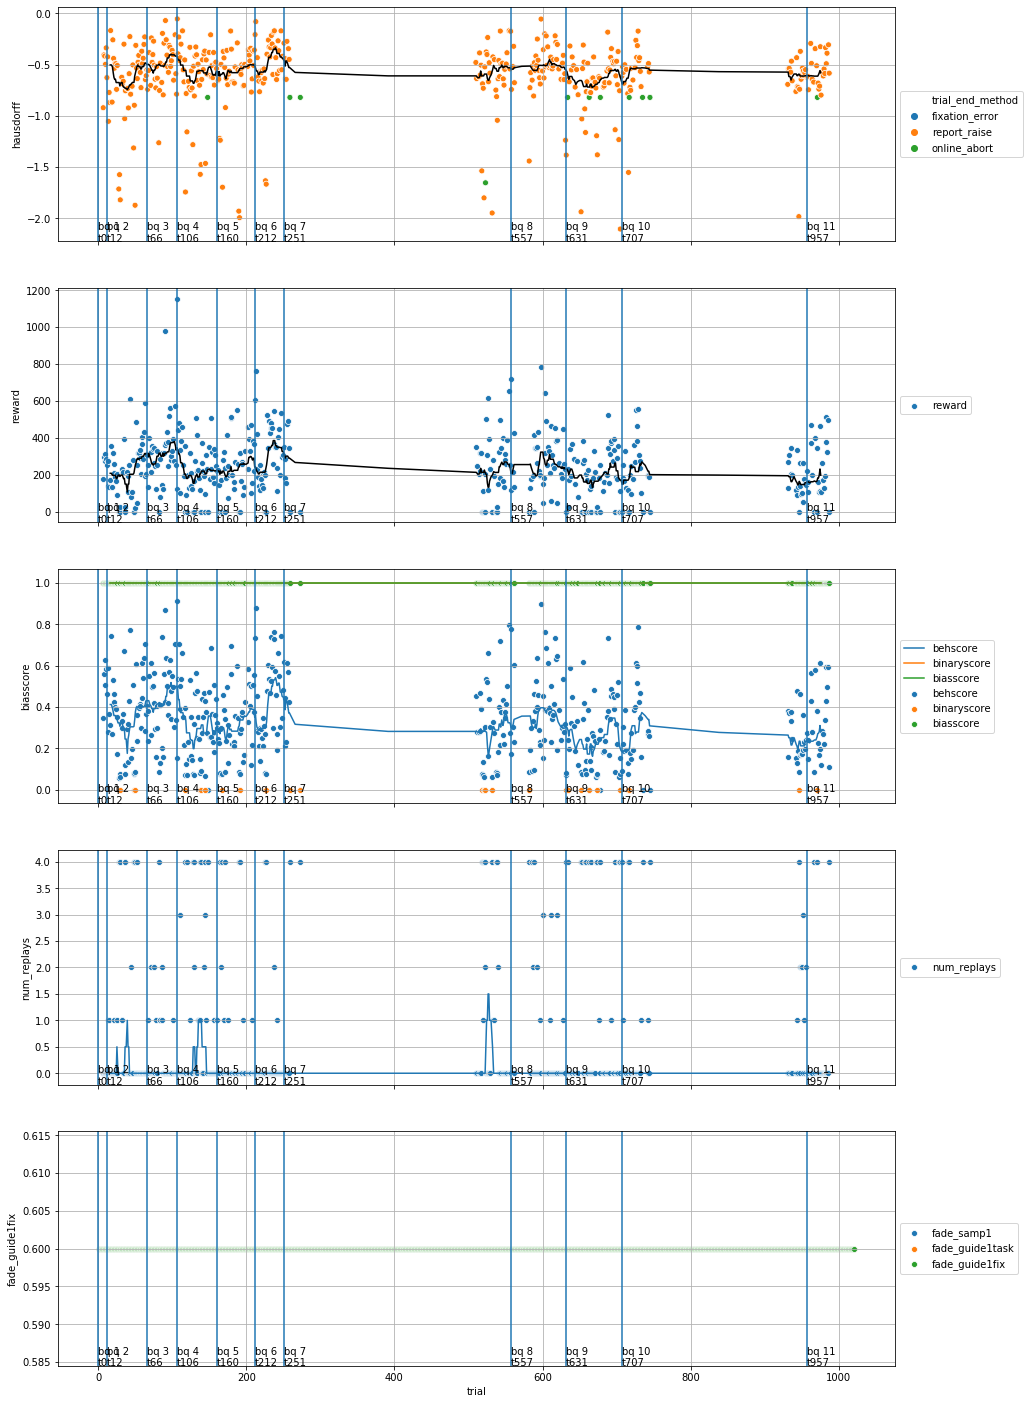

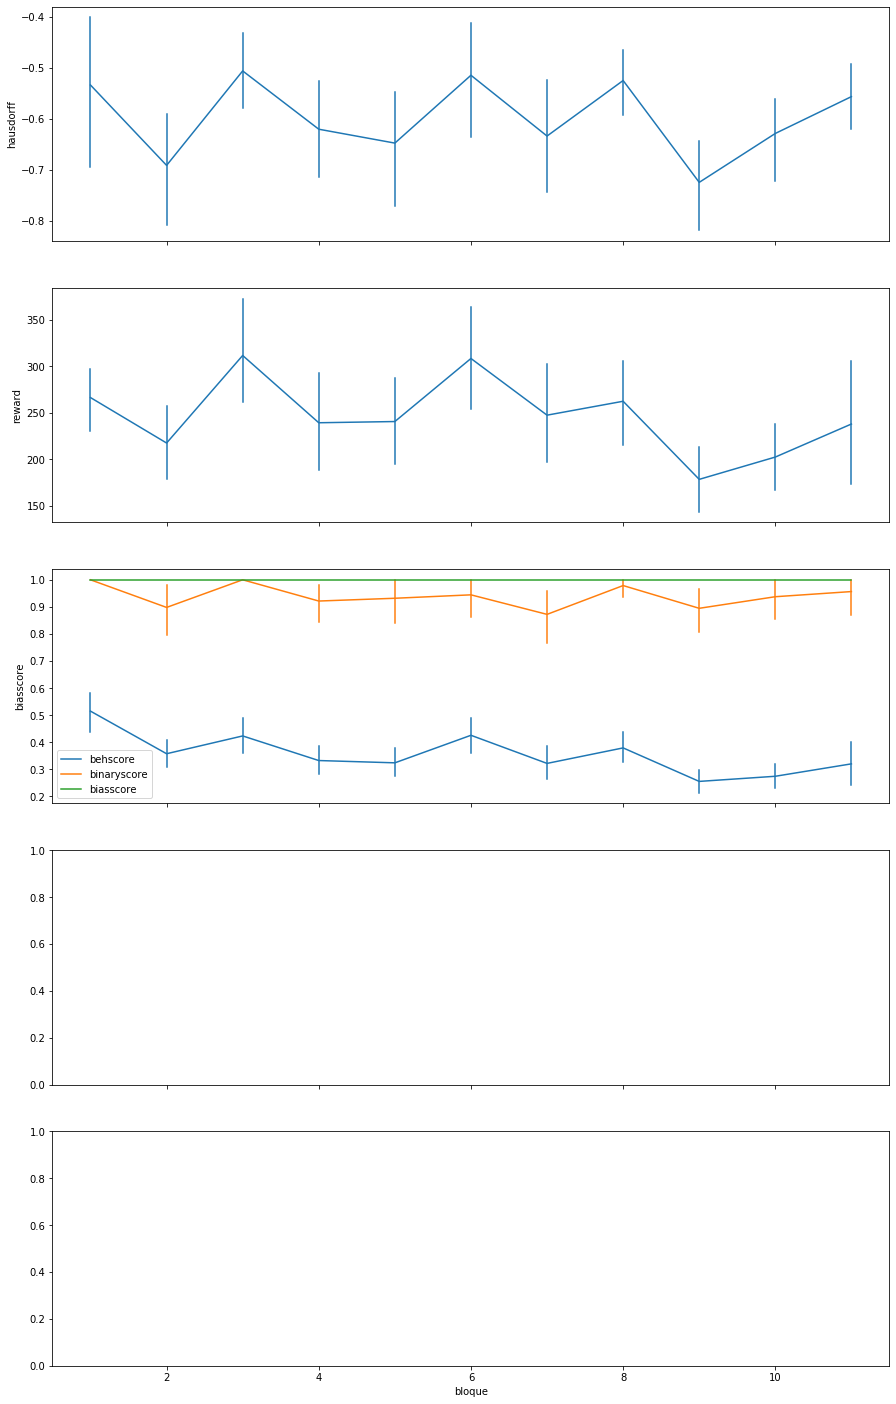

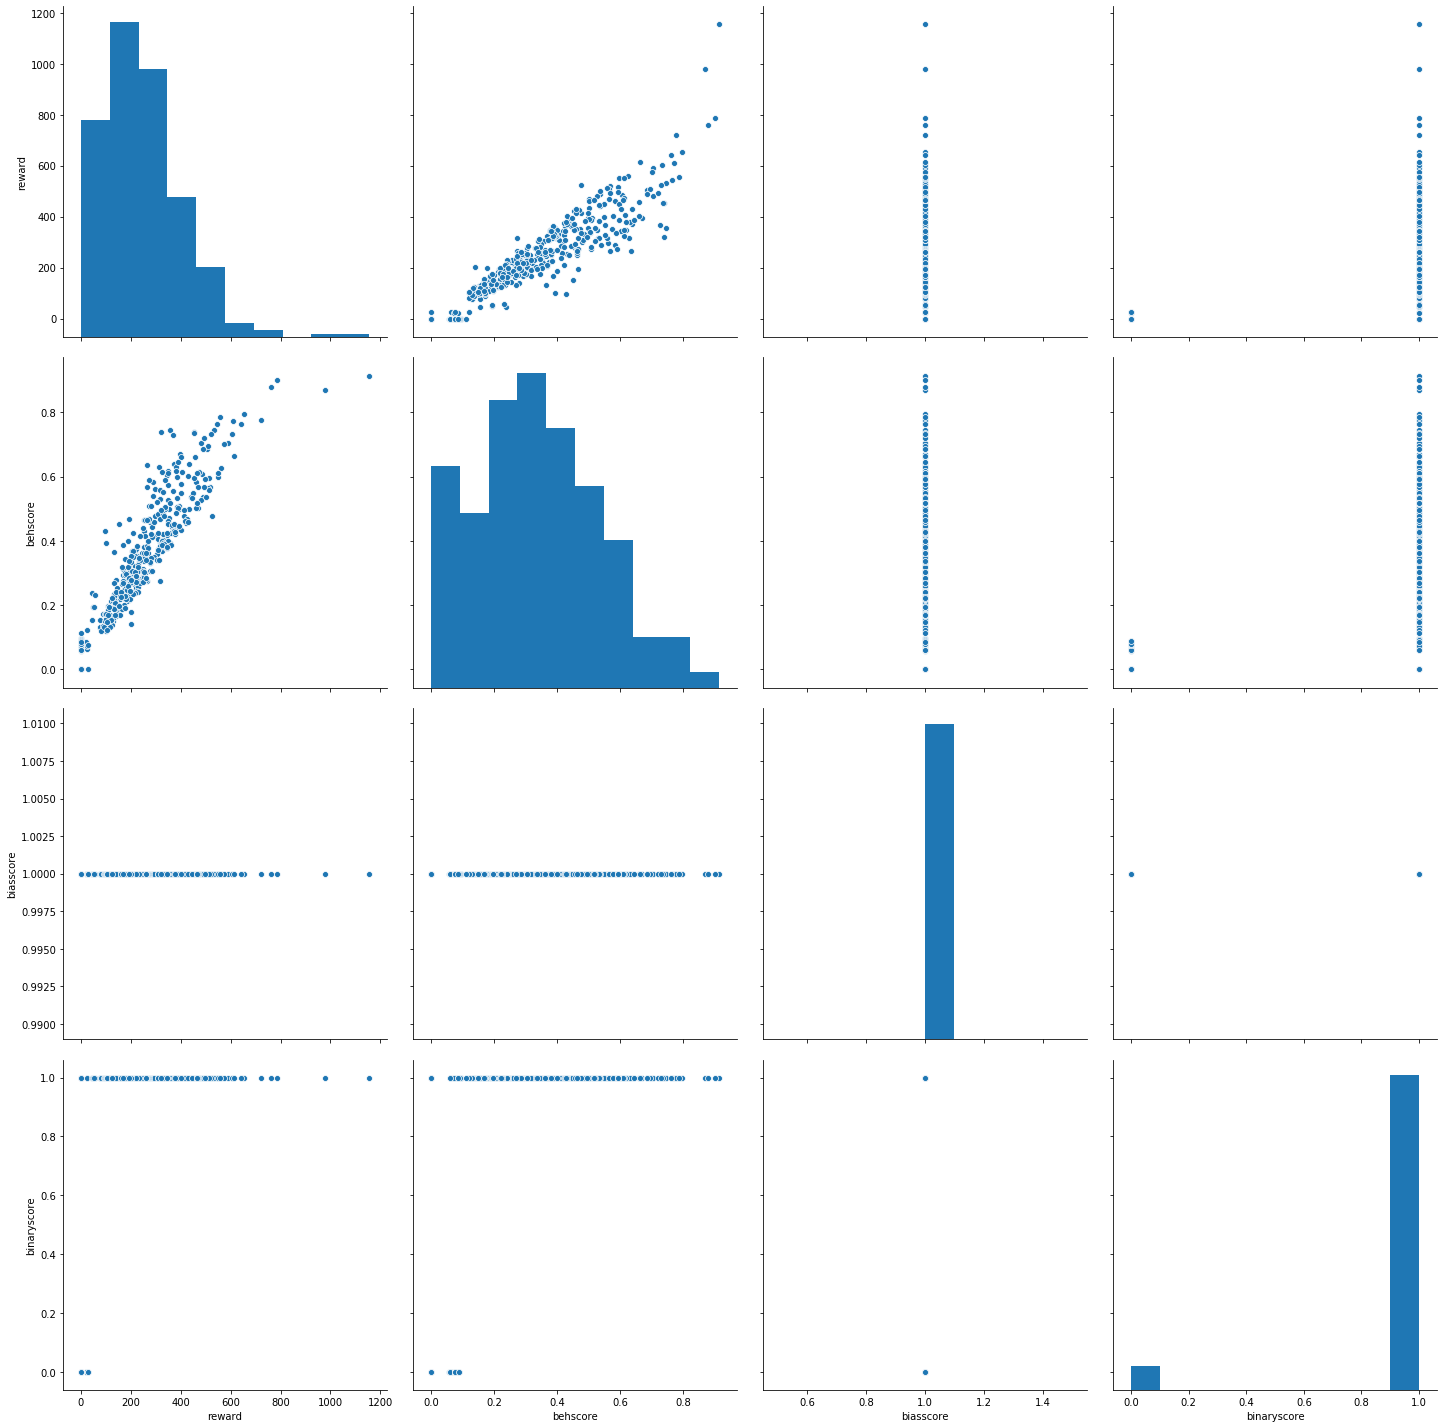

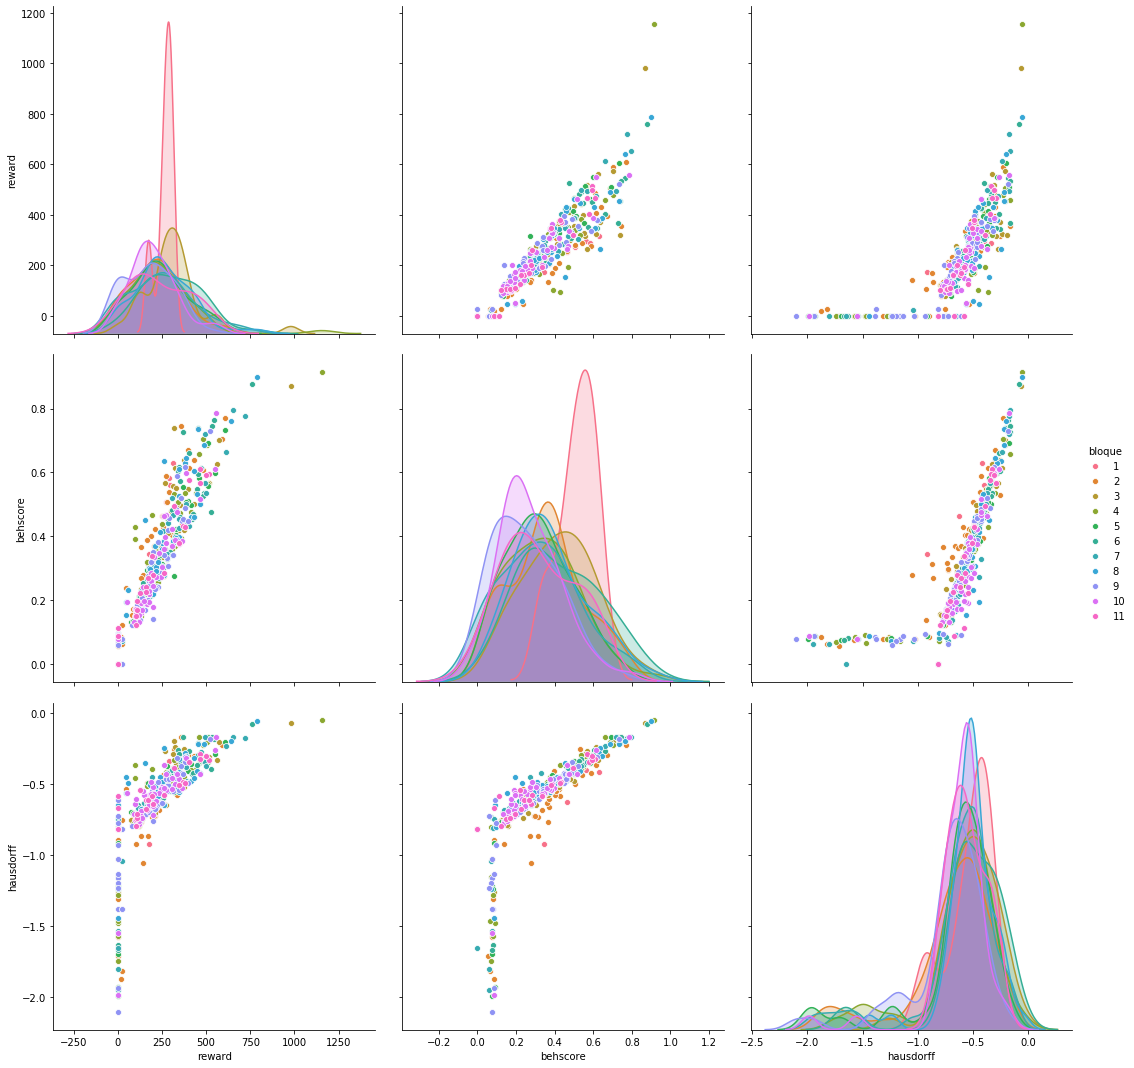

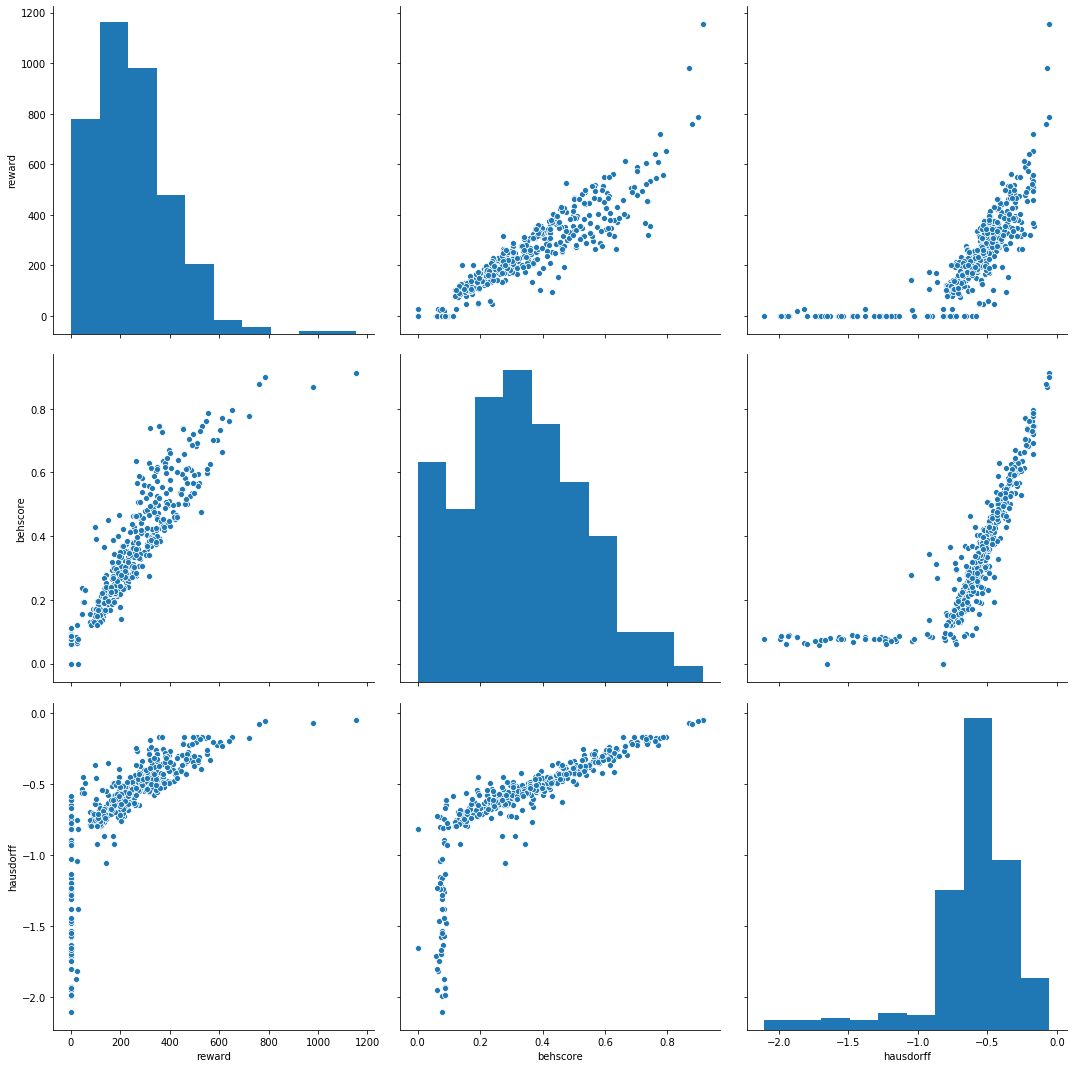

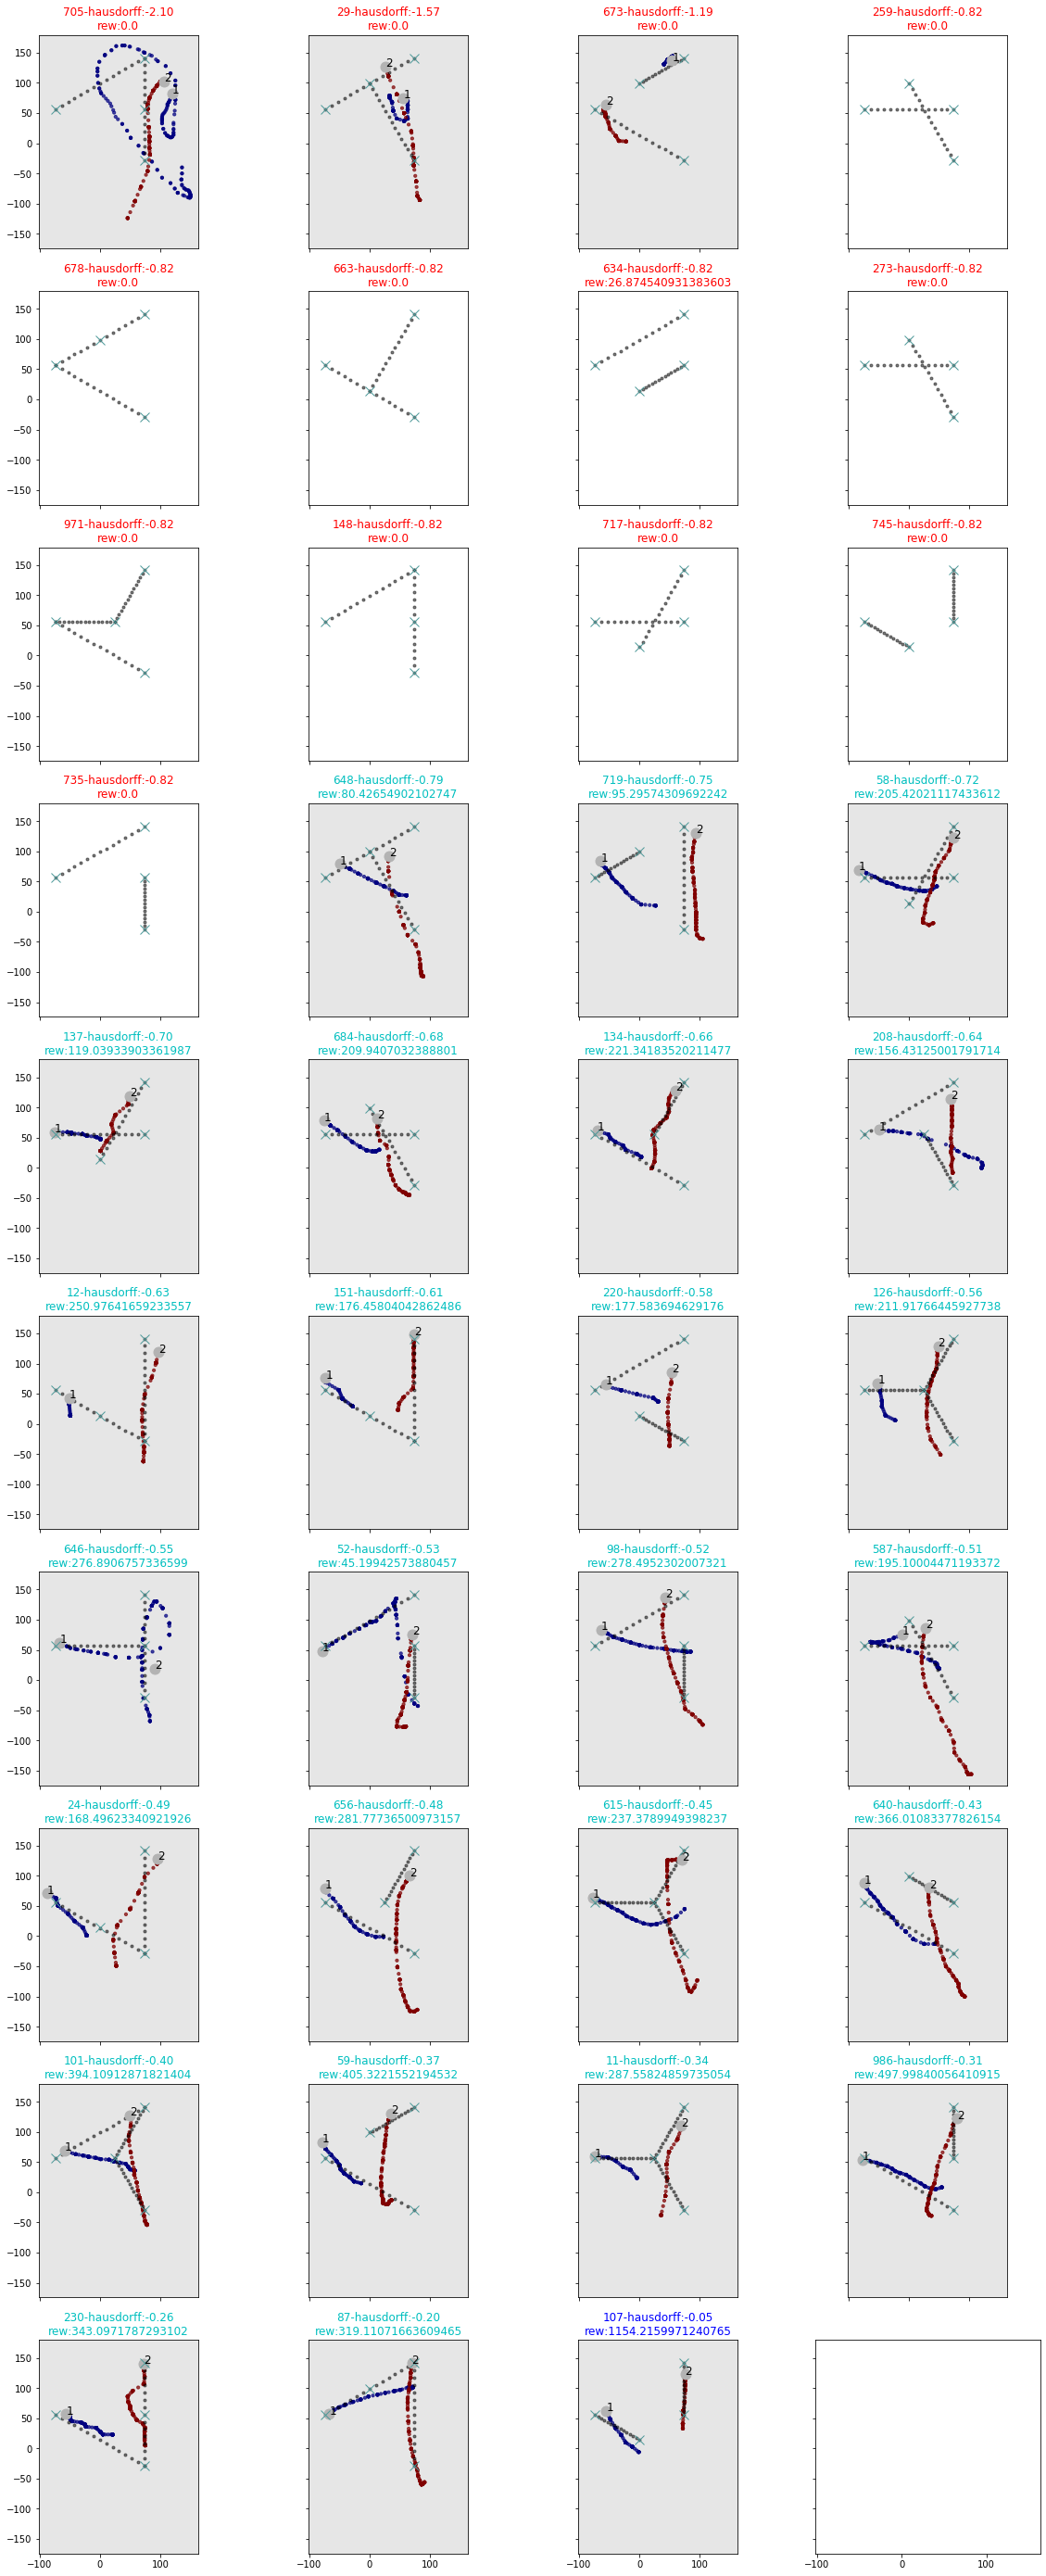

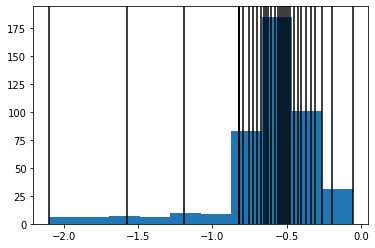

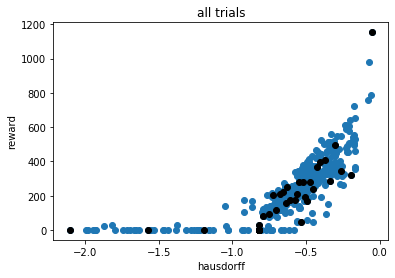

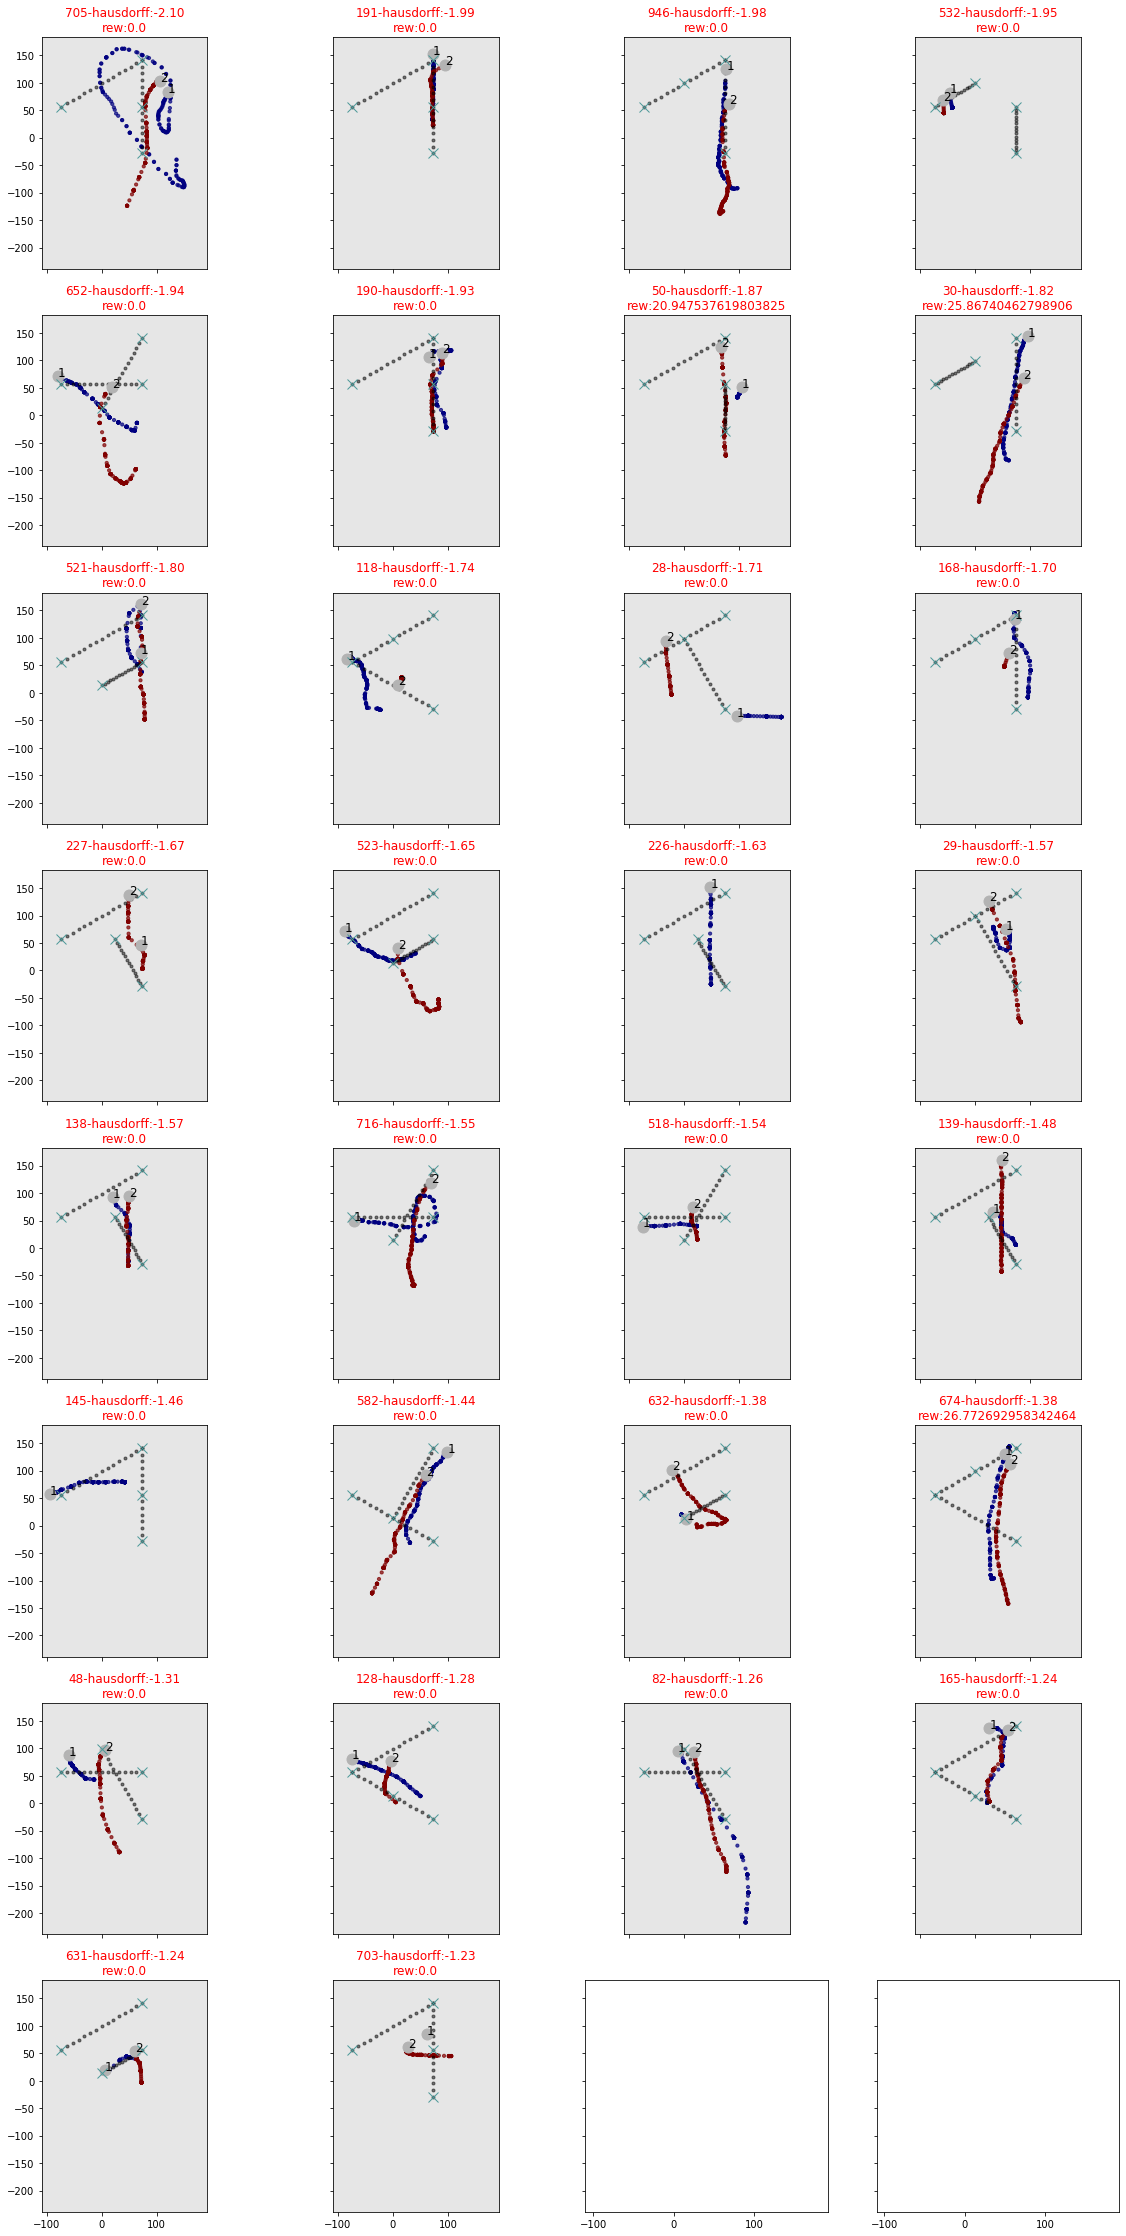

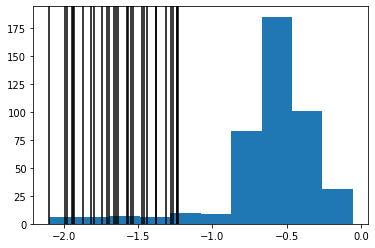

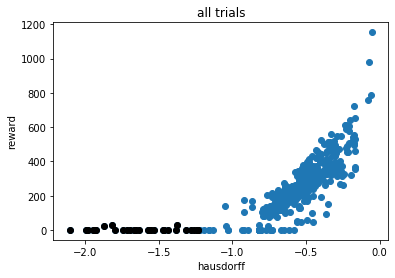

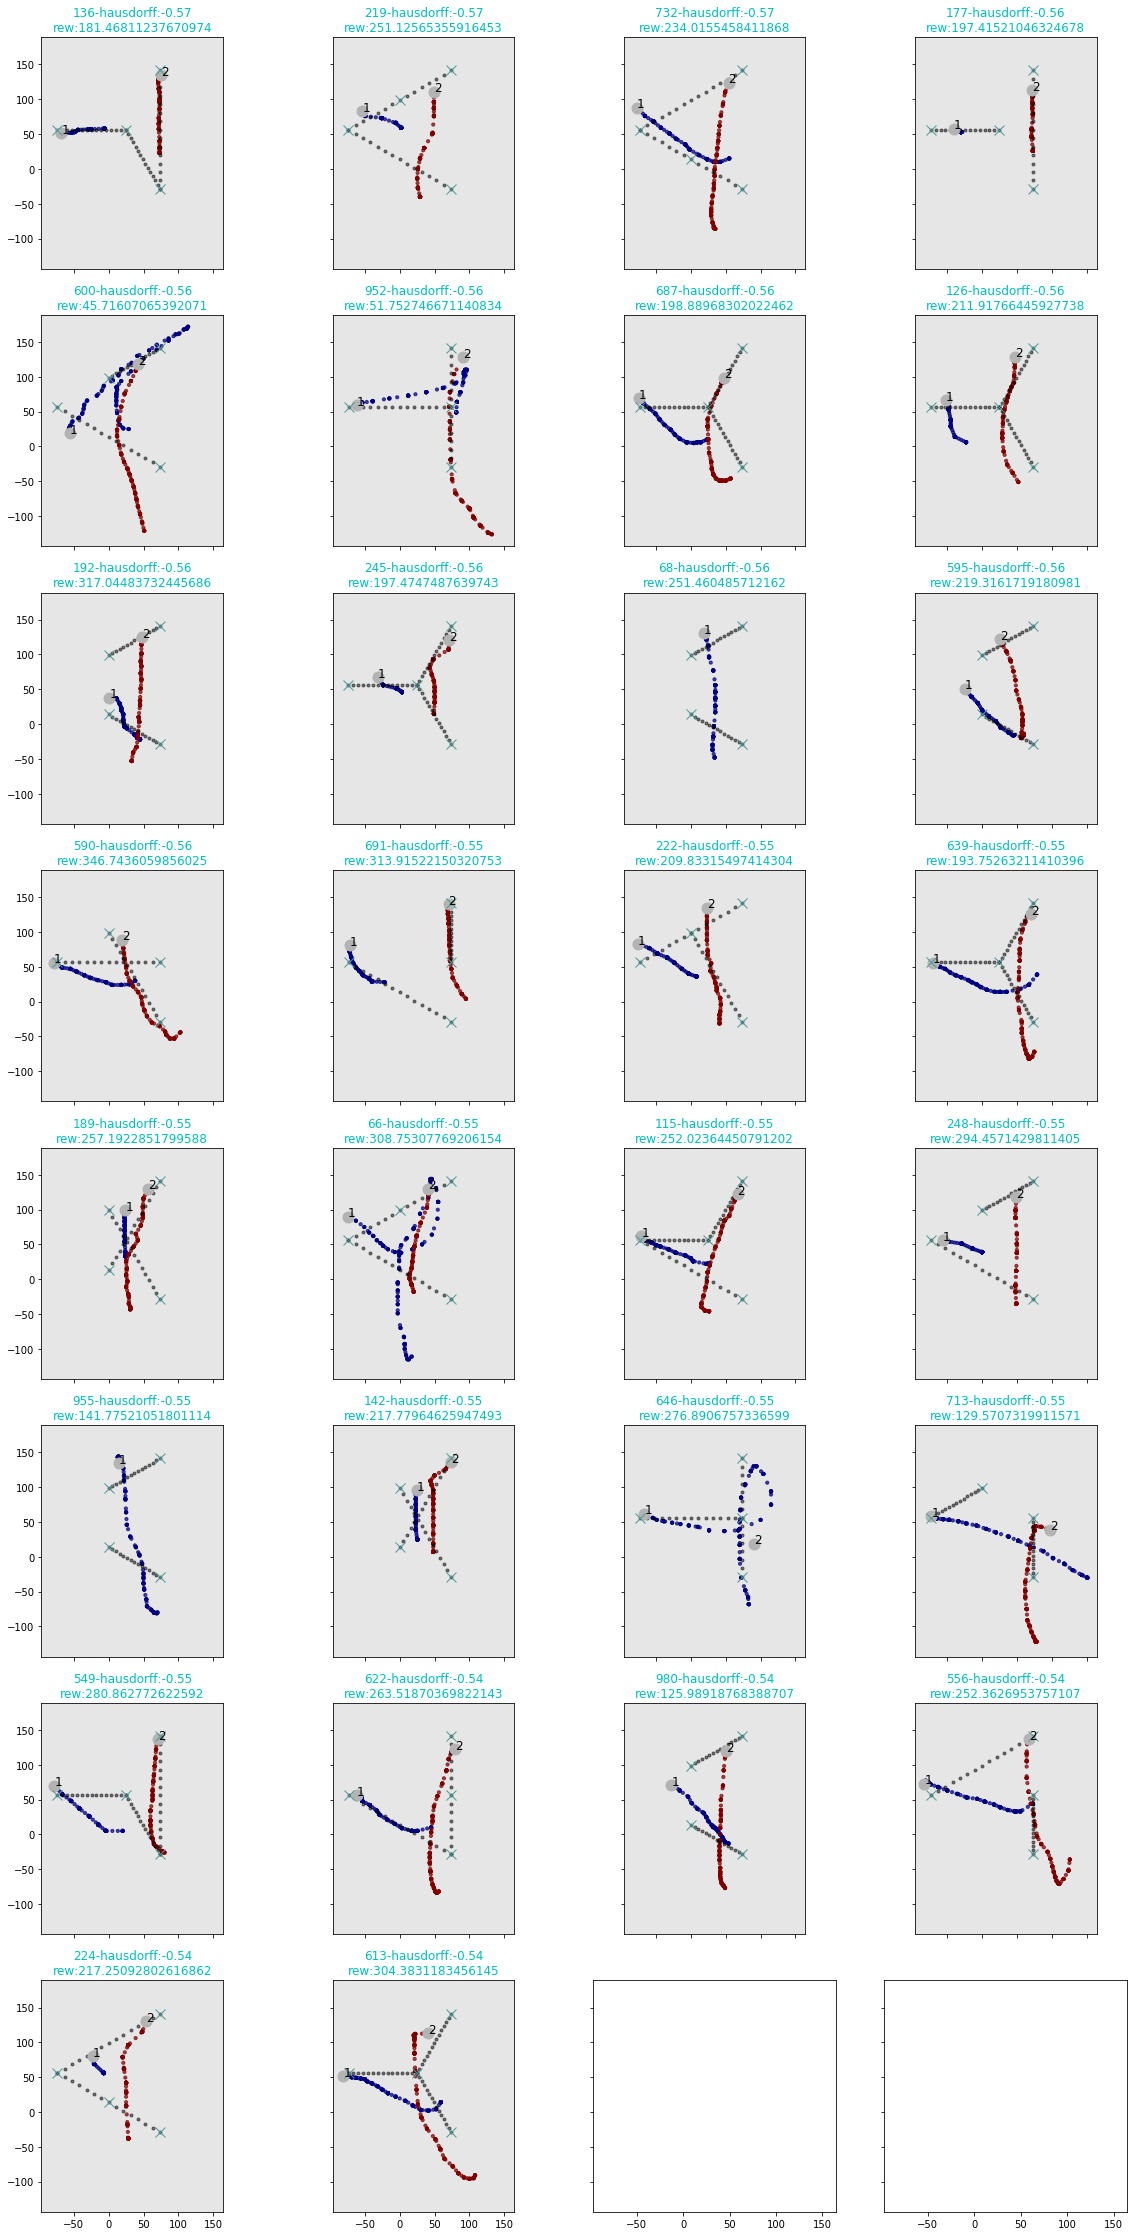

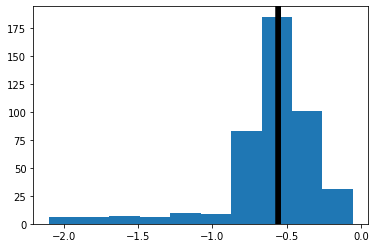

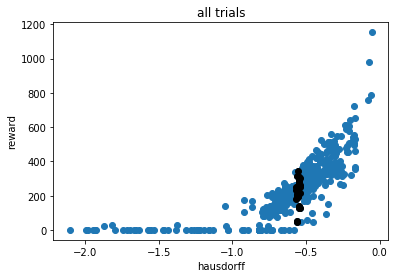

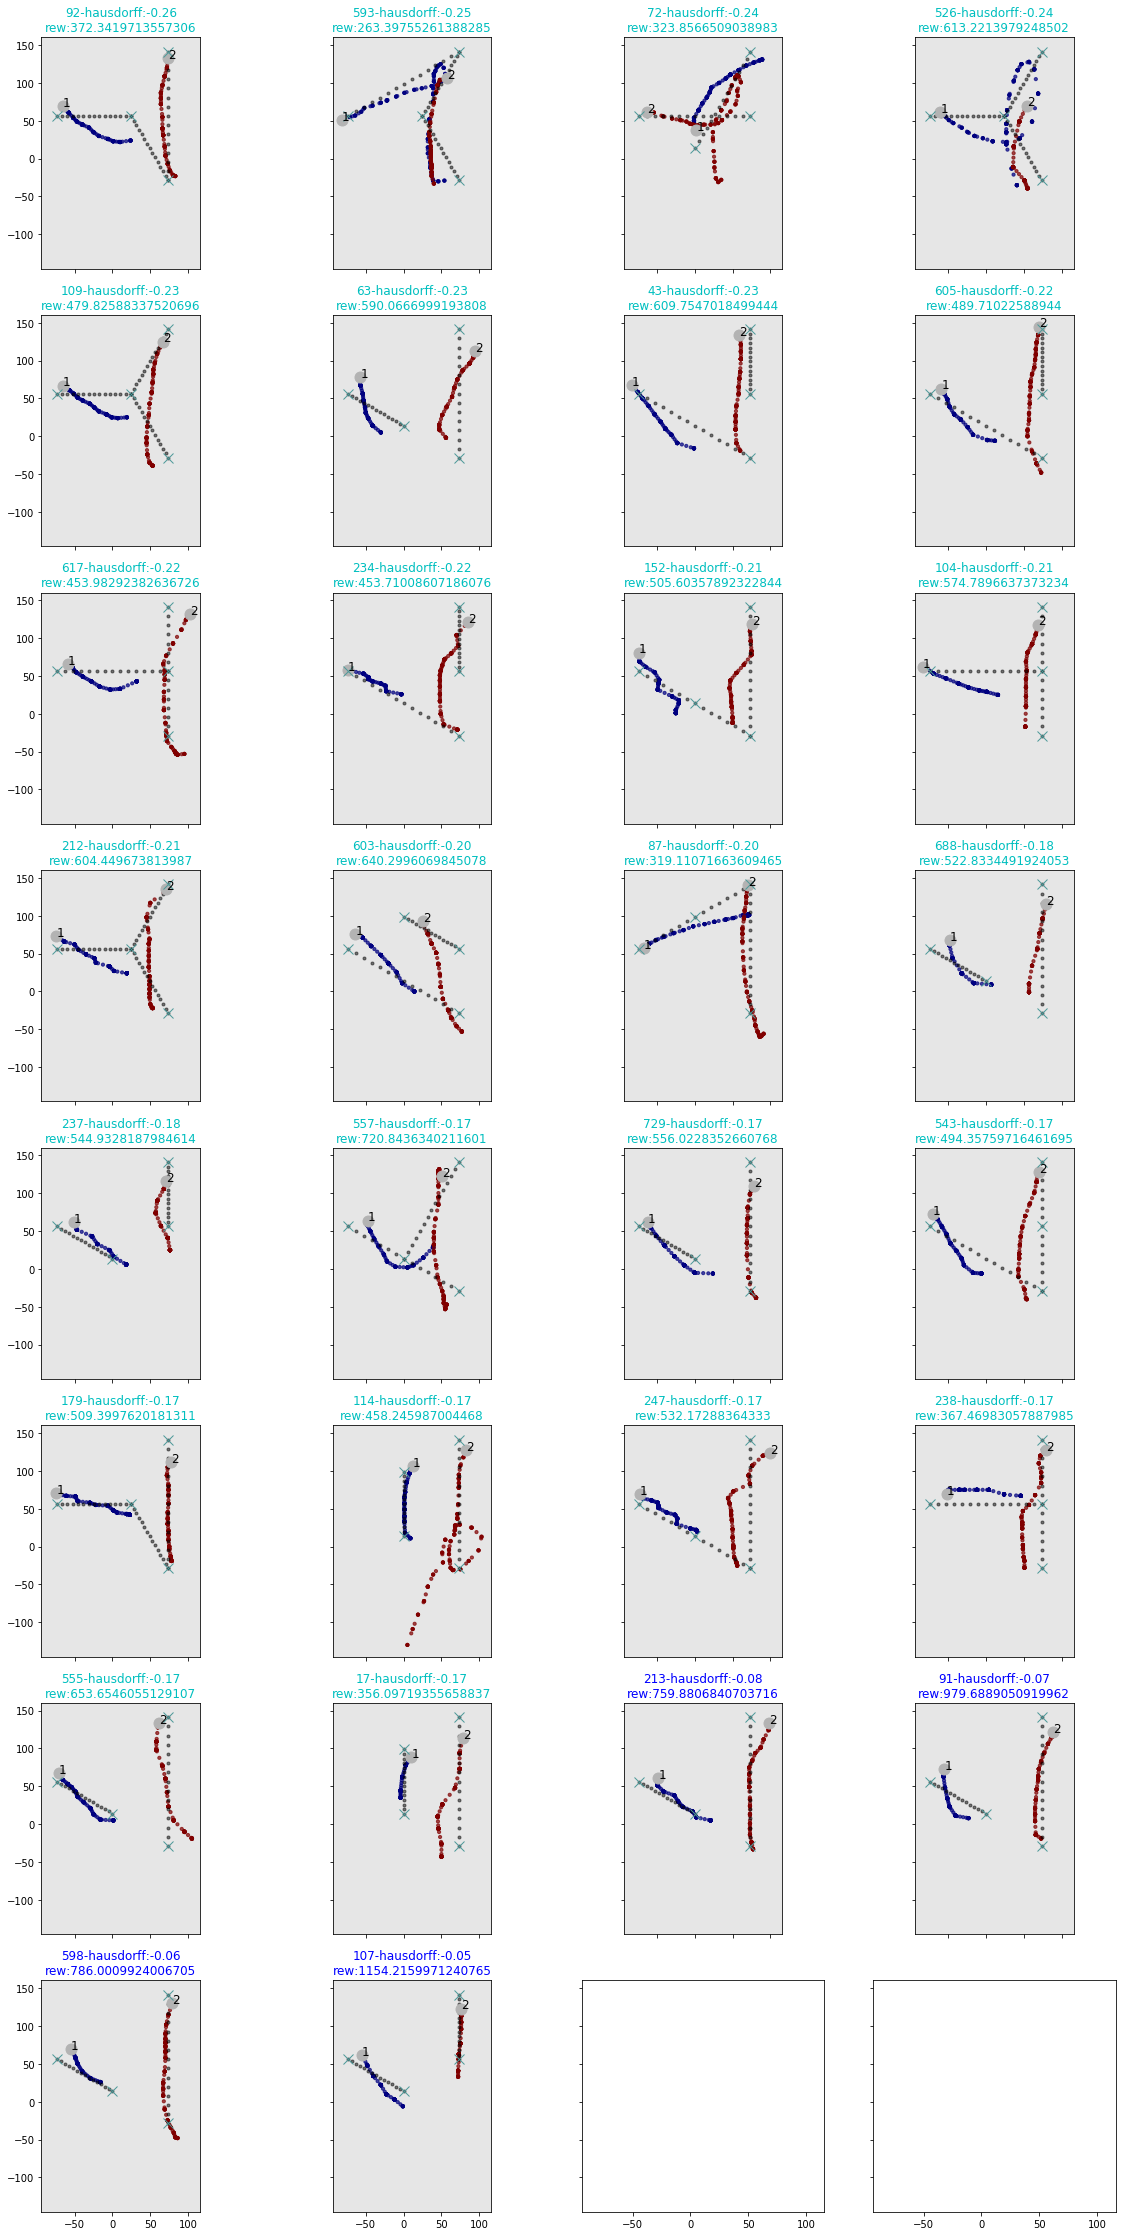

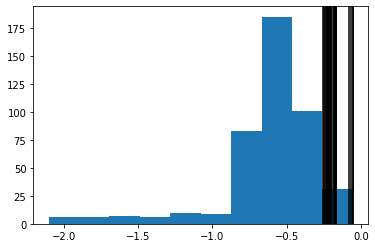

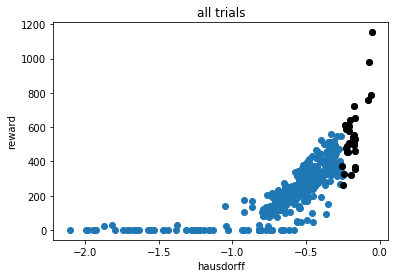

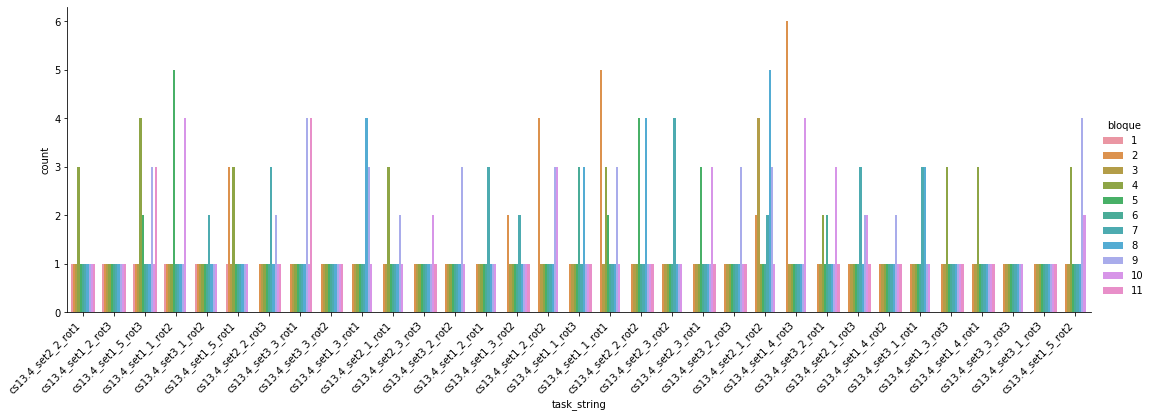

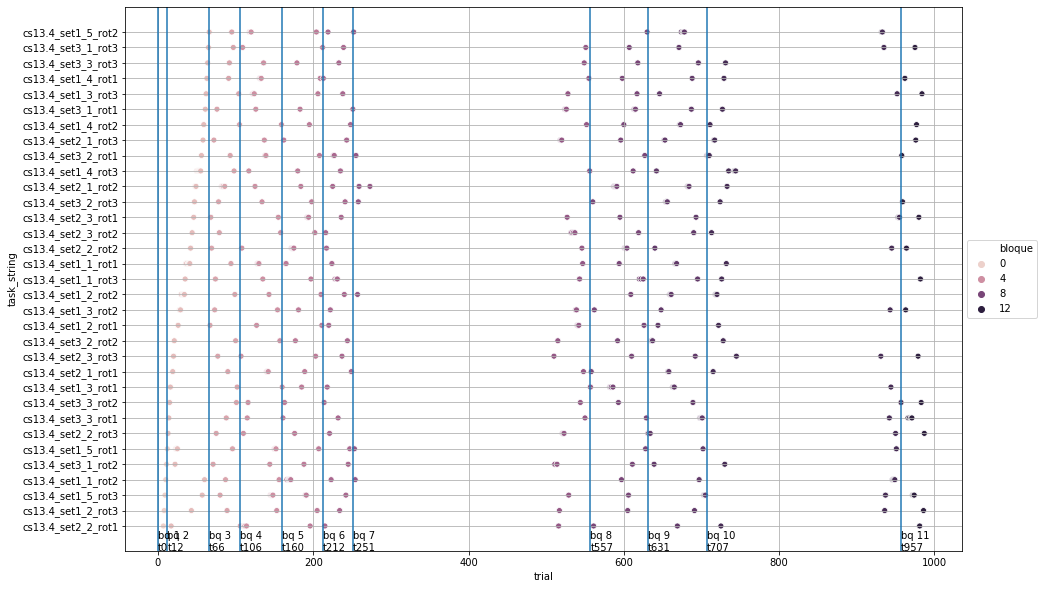

In [82]:
# setup saving dir for figs
SAVEDIRDAY = f"{fd['params']['figuredir']}/dayanalysis"
import os
os.makedirs(SAVEDIRDAY, exist_ok=True)

# 1) overview
df = extractSessionDf(fd)
fig1, fig2 = plotOverview_(df)
fig1.savefig(f"{SAVEDIRDAY}/overview1.pdf")
fig2.savefig(f"{SAVEDIRDAY}/overview2.pdf")

# 2) relationship between reward and factors that go into reward
figs = plotReward(df)
for i, f in enumerate(figs):
    f.savefig(f"{SAVEDIRDAY}/reward_score_{i}.pdf")

# 3) PLOT BEHAVIOR FOR TRIALS SORTED BY SCORE
score_type = "hausdorff"
FIGS = plotBehSortedByScore(df, fd, score_type)
for ver, figs in FIGS.items():
    for i, f in enumerate(figs):
        f.savefig(f"{SAVEDIRDAY}/trialsSortedByScore_{score_type}_{ver}_{i}_.pdf")

# 4) TASK VISUALIZATIONS, SCHEDULE, REPETITION
figs = plotTaskSchedules(df)
for i, f in enumerate(figs):
    f.savefig(f"{SAVEDIRDAY}/taskSchedule{i}.pdf")
    
    

## QUANTIATIVE ANALYSIS

In [ ]:
def gettrials_(fd, df, ALPHA_INVISIBLE = 0.021, clean_strokes=True, unique=False, 
              not_faded=False, trial_range=None):
    """ get list of trials
    - ALPHA_INVISIBLE, for fades, if less than this then is invisible
    - not_faded is positive control, trials without full fade
    - trial_range, inclusive [t1, t2]
    """
    
    # get trials based on fade value
    if not_faded:
        alpha = 0.03
        dfthis = df[(df["fade_samp1"]>alpha) & (df["fade_guide1task"]>alpha) & (df["fade_guide1fix"]>alpha)]
    else:
        dfthis = df[(df["fade_samp1"]<ALPHA_INVISIBLE) & (df["fade_guide1task"]<ALPHA_INVISIBLE) & (df["fade_guide1fix"]<ALPHA_INVISIBLE)]
    trials_list_all = list(dfthis["trial"].values)
    
    # only trials in a certain range
    if trial_range is not None:
        trials_list_all = [t for t in trials_list_all if t>=trial_range[0] and t<=trial_range[1]]
    
    # clean strokes only?
    if clean_strokes:
        print("- only trials with successful fixation")
        trials_list_all = [t for t in trials_list_all if getTrialsFixationSuccess(fd, t)==True]
        
    if unique:
        # then unique trials onlyu
        print("- only unique tasks")
        trials_list_all = removeRedundantTrials(fd, trials_list_all)
        
        
    print("extracted trials")
    print(trials_list_all)
    return trials_list_all

In [ ]:
# trial_range = [0, 328] # pancho
# trial_range = [0, 449] # red
trial_range=None
trials_list_all = gettrials_(fd, df, trial_range=trial_range, unique=True)

In [ ]:
# === plot all (or subset) of tasks
rand_subset = 10
plotMultTrialsSimple(fd, trials_list_all, zoom=True, rand_subset= rand_subset,
                    strokes_ver = "peanuts", plotver="strokes", only_first_n_strokes=3)

## VISUALIZE tasks, first split into categories based on guide dots.

In [ ]:
if False:
    ## ===== [OPTIONAL] pick a category and plot
    cat_to_plot = 8

    trials_this = [t for t,c in zip(trials_list_all, cat_by_angle_all) if c==cat_to_plot]
    print(trials_this)

    rand_subset = None
    plotMultTrialsSimple(fd, trials_this, zoom=True, rand_subset= rand_subset,
                        strokes_ver = "peanuts", plotver="strokes", only_first_n_strokes=3, plot_fix=False)

# Plot all trials, split by user-defined categories 
## Categories generally means trials with identical guide dots

In [ ]:
def set_(filedata, trial):
    """ get the set which this task came from.
    - only relevant for tasks cs13.4"""
    CAT = getTrialsTask(filedata, trial)["metadat"]["category"]
    idx = CAT.find("set")
    assert CAT[idx+4]=="_", "then set is probably not a single digit"

    return int(CAT[idx+3])
    
def center_(filedata, trial):
    if "center" in getTrialsTask(filedata, trial)["metadat"].keys():
        return getTrialsTask(filedata, trial)["metadat"]["center"]
    else:
        indcenter = 6 
        print("sure this is the center ind?")
        return getTrialsGuideDots(fd, t)[indcenter]

    
# 1) collect all data into list of dict
DAT = []
for t in trials_list_all:
    DAT.append({
        "trial":t,
        "set":set_(fd, t),
        "angle":getTrialsTask(fd, t)["metadat"]["angle"][0][0],
        "category":getTrialsTask(fd, t)["metadat"]["category"],
#         "strokes":getTrialsStrokesByPeanuts(fd, t),
        "centerpos":center_(fd, t),
#         "strokestask":getTrialsTaskAsStrokes(fd, t),
        "guidedotcoords":getTrialsGuideDots(fd, t),
#         "score_offline":getTrialsScoreRecomputed(fd, t)
        })

# 2) reorder the trials
order_by = "angle"
if order_by=="angle":
    DAT = sorted(DAT, key=lambda x: x["angle"])

angle_list = sorted(set([D["angle"] for D in DAT]))
category_list = set([d["category"] for d in DAT])
category_list = list(category_list)
set_list = sorted(set([D["set"] for D in DAT]))

In [ ]:
# == Give each guide-dot configuration a unique id 
# (different angles will have same id)

gdConfigs = []

# 1) Set + Angle
ct = 0
for s in set_list:
    
    # get list of possible parameters
    alist = sorted(set([D["angle"] for D in DAT if D["set"]==s]))
    catlist = set([D["category"] for D in DAT if D["set"]==s])
    
    gdConfigs.append({
        "id":ct,
        "angle":alist, # possible angles
        "category":catlist, # possible tasks (name given before applying rotation)
        "set":s
    })        
    
    # assign back to DAT
    for D in DAT:
        if D["angle"] in alist and D["category"] in catlist:
            assert "gd_id" not in D.keys(), "error, this trying to fill twice?"
            D["gd_id"] = ct
    ct+=1
for D in DAT:
    assert "gd_id" in D.keys()

gdConfigs


In [ ]:
# == what variables determine what tasks to lump as a "category" (i.e., plot all together).
PLOT = "angle_set"
REPLAYNUM = 1
figs = []

if PLOT=="angle_set":
    # 2) CATEGORY = (angle, set)
    for a in angle_list:
        for s in set_list:
            trials_this = [d["trial"] for d in DAT if d["angle"]==a and d["set"]==s]

            print(f"plotting these trials for angle: {a}, set {s}")
            print(trials_this)

            rand_subset = None
            fig = plotMultTrialsSimple(fd, trials_this, zoom=True, rand_subset= rand_subset,
                                strokes_ver = "peanuts", plotver="strokes", only_first_n_strokes=3, plot_fix=False, 
                                replaynum=REPLAYNUM)
            figs.append(fig)
            
elif PLOT=="angle":
    # 2) CATEGORY = (angle)
    for a in angle_list:
        trials_this = [d["trial"] for d in DAT if d["angle"]==a]

        print(f"plotting these trials for angle: {a}")
        print(trials_this)

        rand_subset = None
        plotMultTrialsSimple(fd, trials_this, zoom=True, rand_subset= rand_subset,
                            strokes_ver = "peanuts", plotver="strokes", only_first_n_strokes=3, plot_fix=False)
    #     assert FAlse

elif PLOT=="taskcat":
    # 2) CATEGORY = (task category)
    for c in category_list:
        trials_this = [d["trial"] for d in DAT if d["category"]==c]

        print(f"plotting these trials for cateorty: {c}")
        print(trials_this)


        rand_subset = None
        plotMultTrialsSimple(fd, trials_this, zoom=True, rand_subset= rand_subset,
                            strokes_ver = "peanuts", plotver="strokes", only_first_n_strokes=3, plot_fix=False)

for i, f in enumerate(figs):
    f.savefig(f"{SAVEDIR}/trialsBehSortedByCategory{i}.pdf")

## Overlay all trials, one plot for each task
Key comparison is the same guide dots, but different task.
Plot, mean across trials, separated by angle and category (imagine a grid).


In [ ]:
def plotAngleByCatOverlayTrials_(DAT, anglelist, catlist, ver="beh", replaynum=1):
    # FOR each unique guide position configuration, plot tasks (columns) and angles (rows)
    # for each angle and each category, overlay all trials and plot in a grid.
    # - replaynum to 1, will take peanutpos, except when there are replays in which case take first.
    fig, axes = plt.subplots(len(anglelist), len(catlist), sharex=True, 
                             sharey=True, figsize=(len(catlist)*5, len(anglelist)*5))

    for i, a in enumerate(anglelist):
        for ii, c in enumerate(catlist):
            # find all trials with this a and c
            DATTHIS = [D for D in DAT if D["angle"]==a and D["category"]==c]

            # plot each trial on same axis
            ax = axes[i, ii]
            for D in DATTHIS:
                if ver=="task":
                    # only task, no beh
                    plotTrialSimple(fd, D["trial"], ax, zoom=True, post_go_only=True, 
                                   use_peanut_params={"replaynum":replaynum, "active":True}, plotver="randcolor", 
                                    only_first_n_strokes=10, plot_fix=False, overlay_guide_dots=True,
                                   plot_task_stimulus=True, plot_drawing_behavior=False)
                elif ver=="beh":
                    plotTrialSimple(fd, D["trial"], ax, zoom=True, post_go_only=True, 
                                   use_peanut_params={"replaynum":replaynum, "active":True}, plotver="randcolor", 
                                    only_first_n_strokes=10, plot_fix=False, overlay_guide_dots=False,
                                   plot_task_stimulus=False, markersize=9, alpha=0.6)
                else:
                    assert False, "not coded"
                    
    return fig


for replaynum in [None, 1]:
    for g in gdConfigs:

        anglelist = g["angle"]
        catlist = g["category"]

        for ver in ["beh", "task"]:
            fig = plotAngleByCatOverlayTrials_(DAT, anglelist, catlist, ver=ver, replaynum=replaynum)
            fig.savefig(f"{SAVEDIR}/AngleByCatOverlayTrials_{ver}_gconfig{g['id']}_replay{replaynum}.pdf")    



# Quantification
## 1) shuffle analysis
## 2) task by task success + learning


In [ ]:
# for shuffle analysis, data is simply list of trials for beh and task.
for D in DAT:
    D["trial_task"] = D["trial"]



In [ ]:
# save strokes for task and beh, so don't have to extract each time
REPLAYNUM = 1
for D in DAT:
    D["strokes_beh"] = getTrialsStrokesByPeanuts(fd, D["trial"], replaynum=REPLAYNUM)
    D["strokes_task"] = getTrialsTaskAsStrokes(fd, D["trial"])
    
    
# remove empty trials. causes problems later.
DAT = [D for D in DAT if len(D["strokes_beh"])>0]

In [ ]:
# === a summary statistic for entire dataset (distribution and mean of offline hd)
def dist_(strokes_beh, strokes_task, ver1="mean", ver2="max"):
    from pythonlib.tools.vectools import modHausdorffDistance
    if len(strokes_beh)==0:
        return np.nan

    pos_beh = np.concatenate(strokes_beh)
    pos_task = np.concatenate(strokes_task)

    return modHausdorffDistance(pos_beh, pos_task, dims = [0,1], ver1=ver1, ver2=ver2)

def funstat_(DAT, verbose=False):
#     x = np.array([getTwoTrialsScore(fd, d["trial"], d["trial_task"]) for d in DAT])
    x = np.array([dist_(d["strokes_beh"], d["strokes_task"]) for d in DAT])
    if verbose:
        # return also each trial's value
        return (np.nanmean(x), x)
    else:
        return np.nanmean(x)
        
print(funstat_(DAT, False))
    
    
def funshuff_(DAT):
    import copy
    DAT_shuff = copy.deepcopy(DAT)
    
    # all trials that are same guide dot configuration, shuffle those.
    trials_task_gotten = []
    for g in gdConfigs:
        angles = g["angle"]
        gd_id = g["id"]
        cats = g["category"]
        for a in angles:
            # find all trials using this config + angle
            Dthis = [D for D in DAT_shuff if D["gd_id"]==gd_id and D["angle"]==a]

            # shuffle trials for task
            task = [(D["trial_task"], D["strokes_task"]) for D in Dthis]
            random.shuffle(task)
            trials_task_gotten.extend([t[0] for t in task]) # for sanity check after.
#             if 63 in [t[0] for t in task]:
#                 print([t[0] for t in task])
#                 assert False

            # sanity check, make sure all guide positions are the same
            gdpositions = []
            for t in task:
                gdpositions.append(getTrialsGuideDots(fd, t[0]))
            gdpositions = np.array(gdpositions)
            assert(np.all(np.isclose(np.diff(gdpositions, n=1, axis=0), 0.))), "problem, why guide dots are not the same?"                


            # reassign to D
            for D, t in zip(Dthis, task):
                D["trial_task"] = t[0]
                D["strokes_task"] = t[1]
                
                # for troubleshooting:
#                 if D["trial"] == 63:
#                     print(D["strokes_task"][0][5])

    # check that each trial done once and only once
    assert np.all((np.array(sorted(trials_task_gotten)) == np.array(sorted([D["trial_task"] for D in DAT])))), "then trials not gotten once and only once, in shuffle"
#     print(np.array(sorted(trials_task_gotten)))
#     print(np.array(sorted([D["trial_task"] for D in DAT])))
    
    return DAT_shuff
                
for _ in range(10):
    DAT_shuff = funshuff_(DAT)
    print(funstat_(DAT_shuff))




In [ ]:
from pythonlib.tools.statstools import permutationTest
N = 100
p, fig = permutationTest(DAT, funstat_, funshuff_, N, side="left")
# fig.savefig(f"{SAVEDIR}/withinGdconfigShuffle_permutationtest.pdf")

# See shuffle results for each trial

In [ ]:
# === see shuffle results for each trial
p, stat_actual, stats_shuff, fig = permutationTest(DAT, lambda x:funstat_(x, verbose=True), funshuff_, 50, side="left")

In [ ]:
[D for D in DAT if D["trial"]==63]

In [ ]:
# Get "pval" for each trial.
from pythonlib.tools.statstools import empiricalPval
SIDE = "left"
for i in range(len(stat_actual)):
    if np.isnan(stat_actual[i]):
        p = np.nan
    else:
        p = empiricalPval(stat_actual[i], [s[i] for s in stats_shuff], side=SIDE)
    
    # - put back into DAT
    DAT[i]["pval"]=p
    DAT[i]["stat_actual"] = stat_actual[i]
    DAT[i]["stats_shuff"] = [s[i] for s in stats_shuff]
    DAT[i]["effect_size"] = stat_actual[i] - np.mean([s[i] for s in stats_shuff])

    

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols = 1, sharex=True, squeeze=False, figsize=(20, 5*4))

# Plot
ax = axes[0,0]
x = [D["trial"] for D in DAT]
y = [D["pval"] for D in DAT]
ax.plot(x,y,'xk')
for xx, yy in zip(x,y):
    if yy<1:
        ax.text(xx,yy,xx, color="r")
ax.set_xlabel("trial")
ax.set_ylabel("p-val, from permutation test")

# Plot
ax = axes[1,0]
x = [D["trial"] for D in DAT]
y = [D["stat_actual"]-np.mean(D["stats_shuff"]) for D in DAT]
ax.plot(x,y,'xk')
for xx, yy in zip(x,y):
    if np.abs(yy)>10:
        ax.text(xx+1,yy,xx, color="r")
ax.set_xlabel("trial")
ax.set_ylabel("stats_actual - mean(stats_shuff)")

# Plot
ax = axes[2,0]
x = [D["trial"] for D in DAT]
y = [D["stat_actual"]-np.mean(D["stats_shuff"]) for D in DAT]
gdset = [D["set"] for D in DAT]
scatter = ax.scatter(x,y,c=gdset, label=gdset)
legend1 = ax.legend(*scatter.legend_elements(), title="guidedot sets")
ax.add_artist(legend1)# for xx, yy in zip(x,y):
#     if np.abs(yy)>10:
#         ax.text(xx+1,yy,xx, color="r")
ax.set_xlabel("trial")
ax.set_ylabel("stats_actual - mean(stats_shuff)")
ax.axhline(0)

# Plot
ax = axes[3,0]
for i in range(len(DAT)):
    xx = DAT[i]["trial"]
    yy = DAT[i]["stat_actual"]
    ax.axvline(xx, alpha=0.2, linestyle="-")
    ax.plot(np.ones_like(yy)*xx,yy,'or')
    yy = DAT[i]["stats_shuff"]
    ax.plot(np.ones_like(yy)*xx,yy,'xk', alpha=0.2)
    
    yyy = DAT[i]["stat_actual"]-np.mean(DAT[i]["stats_shuff"])
    if np.abs(yyy)>10:
        ax.text(xx,DAT[i]["stat_actual"],xx, color="r")
ax.set_xlabel("trial")
ax.set_ylabel("dist")


# Plot
ax = axes[4,0]
x = [D["trial"] for D in DAT if ~np.isnan(D["stat_actual"])]
y = [len(set(D["stats_shuff"])) for D in DAT if ~np.isnan(D["stat_actual"])]
    
ax.plot(x,y,'xk')
for xx, yy in zip(x,y):
    if yy>3:
        ax.text(xx,yy,xx, color="r")
ax.set_xlabel("trial")
ax.set_ylabel("num unique tasks")

# -- save
# fig.savefig(f"{SAVEDIR}/withinGdconfigShuffle_eachtrial.pdf")

In [ ]:
# == pull out the top 20 trials
trialrange = [100, 350] # within this range
trialrange = [350, 500] # within this range
trialrange = [0, 1000] # within this range

import copy
DATTHIS = copy.deepcopy(DAT)
DATTHIS = sorted(DATTHIS, key = lambda x: x["effect_size"])

trials = [D["trial"] for D in DATTHIS]
trials = [t for t in trials if t>=trialrange[0] and t<=trialrange[1]]



In [ ]:
DTHIS = [D for D in DAT if D["trial"]==179][0]
plt.figure()
ax = plt.subplot(111)
plotDatStrokes(DTHIS["strokes_beh"], ax, )


In [ ]:
plotTrialSimple(fd, 113, use_peanut_params={'replaynum': 1, 'active': True}, zoom=True)

In [ ]:
## playing around with different variants of hd distance
if True:
    ver1="max"
    ver2="max"
    print(dist_(getTrialsStrokesByPeanuts(fd, 113, replaynum=1), getTrialsTaskAsStrokes(fd, 86), ver1, ver2))
    print(dist_(getTrialsStrokesByPeanuts(fd, 113, replaynum=1), getTrialsTaskAsStrokes(fd, 113), ver1, ver2))

In [ ]:
# -- Best 20
N = 30
trialsthis = trials[:N]
print(trialsthis)
fig = plotMultTrialsSimple(fd, trialsthis, zoom=True, plot_fix=False, plotver="strokes",
                    strokes_ver="peanuts", replaynum=1)

fig.savefig(f"{SAVEDIR}/withinGdconfigShuffle_eachtrial_best{N}.pdf")

In [ ]:
# -- Worst 20
N = 20
trialsthis = trials[-N:]
print(trialsthis)
fig = plotMultTrialsSimple(fd, trialsthis, zoom=True, plot_fix=False, plotver="strokes",
                    strokes_ver="peanuts", replaynum=1)
fig.savefig(f"{SAVEDIR}/withinGdconfigShuffle_eachtrial_worst{N}.pdf")

In [ ]:

## SANITY CHECK - If shuffle all trials, should see big effect of task.
if False:
    def funshuff_(DAT):
        import copy
        DAT_shuff = copy.deepcopy(DAT)

        # shuffle trials for task
        task = [(D["trial_task"], D["strokes_task"]) for D in DAT_shuff]
        random.shuffle(task)

        # reassign to D
        for D, t in zip(DAT_shuff, task):
            D["trial_task"] = t[0]
            D["strokes_task"] = t[1]

        return DAT_shuff

    from pythonlib.tools.statstools import permutationTest
    permutationTest(DAT, funstat_, funshuff_, 100, side="left")

## Becoming more stereotyped over trials?

In [ ]:
# Split trials into bins across day
# within each bin, 

DISTS = []
for g in gdConfigs:
    angles = g["angle"]
    cats = g["category"]
    for a in angles:
        for c in cats:
            
            # get dat for this config
            DATTHIS = [D for D in DAT if D["angle"]==a and D["category"]==c and D["gd_id"]==g["id"]]

            # split into early and late
            DATTHIS = sorted(DATTHIS, key=lambda x: x["trial"])

            n = round(len(DATTHIS)/2)
            DATTHIS_early = DATTHIS[:n]
            DATTHIS_late = DATTHIS[n:]

            # - get all parwise distances 
            def allpairdists_(DAT):
                n = len(DAT)
                dists = []
                for i in range(n):
                    for ii in range(i+1,n):
                        d = dist_(DAT[i]["strokes_beh"], DAT[ii]["strokes_beh"])
                        dists.append(d)
                return dists
            dists_ee = allpairdists_(DATTHIS_early)
            dists_ll = allpairdists_(DATTHIS_late)
            dists_el = []
            for D1 in DATTHIS_early:
                for D2 in DATTHIS_late:
                    dists_el.append(dist_(D1["strokes_beh"], D2["strokes_beh"]))

            DISTS.append((dists_ee, dists_ll, dists_el))




In [ ]:
# Split trials into bins across day
# within each bin, 

DISTS = []
for g in gdConfigs:
    angles = g["angle"]
    for a in angles:
        # get dat for this config
        DATTHIS = [D for D in DAT if D["angle"]==a and D["gd_id"]==g["id"]]

        # split into early and late
        DATTHIS = sorted(DATTHIS, key=lambda x: x["trial"])

        n = round(len(DATTHIS)/2)
        DATTHIS_early = DATTHIS[:n]
        DATTHIS_late = DATTHIS[n:]

        # - get all parwise distances 
        def allpairdists_(DAT):
            n = len(DAT)
            dists = []
            for i in range(n):
                for ii in range(i+1,n):
                    d = dist_(DAT[i]["strokes_beh"], DAT[ii]["strokes_beh"])
                    dists.append(d)
            return dists
        dists_ee = allpairdists_(DATTHIS_early)
        dists_ll = allpairdists_(DATTHIS_late)
        dists_el = []
        for D1 in DATTHIS_early:
            for D2 in DATTHIS_late:
                dists_el.append(dist_(D1["strokes_beh"], D2["strokes_beh"]))

        DISTS.append((dists_ee, dists_ll, dists_el))




In [ ]:
fig = plt.figure()
for D in DISTS:
#     x = [1,2,3]
    x = ["early-early", "late-late", "early-late"]
    y = [np.mean(DD) for DD in D]
    plt.plot(x,y,"-ok")
    plt.xlabel("comparison (splitting trials in half)")
    plt.ylabel("modHD, pairwise all trials")
    plt.title("each line, unique gd config (angle x gd_id)")
fig.savefig(f"{SAVEDIR}/pairwiseDistChangeOverDay.pdf")


## OLDER

### TO ITERATE OVER EXPERIMENTS


In [ ]:
# AD = (
#     ("Pancho", 200816, 1),
#     ("Pancho", 200817, 1),
#     ("Red", 200816, 2),
#     ("Red", 200817, 1)
# )


# from tools.preprocess import *
# import seaborn as sns

# for animal, date, session in AD:
# #     animal = "Pancho"
# #     date = 200816
#     expt = "pilot"
# #     session = 1

#     fd = loadSingleData(animal, date, expt, session, resave_as_dict=False, load_resaved_data=True, 
#                           resave_overwrite=False)

#     ############ START HERE
#     df = extractSessionDf(fd)

#     for fadestatus in ["faded", "notfaded"]:
        
#         ###### GET TRIALS
#         if fadestatus=="faded":
#             # get trials based on fade value
#             ALPHA_INVISIBLE = 0.021
#             ## === WHICH TRIALS?
#             # Filter by fade values
#             dfthis = df[(df["fade_samp1"]<ALPHA_INVISIBLE) & (df["fade_guide1task"]<ALPHA_INVISIBLE) & (df["fade_guide1fix"]<ALPHA_INVISIBLE)]
#         elif fadestatus=="notfaded":
#             # get trials based on fade value
#             ALPHA_INVISIBLE = 0.03
#             ## === WHICH TRIALS?
#             # Filter by fade values
#             dfthis = df[(df["fade_samp1"]>ALPHA_INVISIBLE)]

#         trials_list_all = list(dfthis["trial"].values)
#         ## === only keep trials that success fixation
#         T = getIndsTrials(fd, keep_only_if_go=True)
#         trials_list_all = [t for t in trials_list_all if t in T]


#         ########################## plot
#         # 1) collect all data into list of dict
#         indcenter = 6
#         DAT = []
#         for t in trials_list_all:
#             DAT.append({
#                 "angle":getTrialsTask(fd, t)["metadat"]["angle"][0][0],
#                 "category":getTrialsTask(fd, t)["metadat"]["category"],
#                 "strokes":getTrialsStrokesByPeanuts(fd, t),
#                 "centerpos":getTrialsGuideDots(fd, t)[indcenter],
#                 "strokestask":getTrialsTaskAsStrokes(fd, t),
#                 "trial":t
#                 })

#         # 2) reorder the trials
#         order_by = "angle"
#         if order_by=="angle":
#             DAT = sorted(DAT, key=lambda x: x["angle"])


#         ################ PLOT GRID
#         for plot_example in [True, False]:
#             nexamples = 2
#             for nstrokes in [1,2,3, 10]:
                
#                 # =============== PLOT
#                 # for each angle and each category, overlay all trials and plot in a grid.
#                 angle_list = sorted(set([D["angle"] for D in DAT]))
#                 category_list = list(category_list)

#                 fig, axes = plt.subplots(len(angle_list), len(category_list), sharex=True, 
#                                          sharey=True, figsize=(len(category_list)*6, len(angle_list)*6))
#                 for i, a in enumerate(angle_list):
#                     for ii, c in enumerate(category_list):
#                         # find all trials with this a and c
#                         DATTHIS = [D for D in DAT if D["angle"]==a and D["category"]==c]

#                         if plot_example:
#                             # then get random subset
#                             DATTHIS = random.sample(DATTHIS, min((nexamples, len(DATTHIS))))
                            
#                         # plot each trial on same axis
#                         ax = axes[i, ii]
#                         for j, D in enumerate(DATTHIS):
#     #                         plot_task_stimulus = j==0
#     #                         plotTrialSimple(fd, D["trial"], ax, zoom=True, post_go_only=True, 
#     #                                        use_peanut_params={"replaynum":None, "active":True}, plotver="randcolor", 
#     #                                         only_first_n_strokes=nstrokes, plot_fix=False, overlay_guide_dots=True,
#     #                                        plot_task_stimulus=plot_task_stimulus, markersize=9, alpha=0.6)
#                             plotTrialSimple(fd, D["trial"], ax, zoom=True, post_go_only=True, 
#                                            use_peanut_params={"replaynum":None, "active":True}, plotver="randcolor", 
#                                             only_first_n_strokes=nstrokes, plot_fix=False, overlay_guide_dots=False,
#                                            plot_task_stimulus=False, markersize=9, alpha=0.6)

#                 fig.savefig(f"/tmp/{animal}_{date}_{session}_{fadestatus}_nstrokes{nstrokes}_example{plot_example}.pdf")

#         ### ====== PLOT JUST THE TASKS.
#         fig, axes = plt.subplots(len(angle_list), len(category_list), sharex=True, 
#                                  sharey=True, figsize=(len(category_list)*6, len(angle_list)*6))
#         for i, a in enumerate(angle_list):
#             for ii, c in enumerate(category_list):
#                 # find all trials with this a and c
#                 DATTHIS = [D for D in DAT if D["angle"]==a and D["category"]==c]

#                 # plot each trial on same axis
#                 ax = axes[i, ii]
#                 for j, D in enumerate(DATTHIS):
#                     if j==0:
#                         plotTrialSimple(fd, D["trial"], ax, zoom=True, post_go_only=True, 
#                                        use_peanut_params={"replaynum":None, "active":True}, plotver="randcolor", 
#                                         plot_fix=False, overlay_guide_dots=True, plot_task_stimulus=True, 
#                                         markersize=9, alpha=0.6, plot_drawing_behavior=False)

#         fig.savefig(f"/tmp/{animal}_{date}_{session}_{fadestatus}_tasks.pdf")
        